# Coronavirus Data Analysis

This notebook shows how to load and do basic analysis with datasets from:
* New York Times
* Israel Ministry of Health

In [1]:
# Uncomment this line below if you get errors about imports:
# !pip install pandas seaborn numpy
import os
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
pd.plotting.register_matplotlib_converters()    
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize': (16, 6)})

## Dataset from New York Times

This dataset contains the number of cases and deaths for every county in the USA. It is useful for time series analysis that can inform decision makers what part of the country will need resources and other interventions. We show a way to analyze recent growth rate to find places where rapid transmission may be happening.

In [3]:
us_counties = pd.read_csv('nyt_data/us-counties.csv')
us_states = pd.read_csv('nyt_data/us-states.csv')
us = pd.read_csv('nyt_data/us.csv')

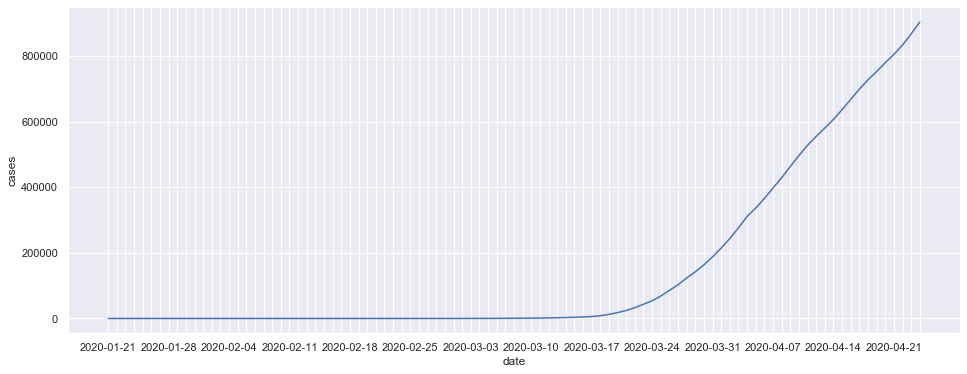

In [4]:
plot = sns.lineplot(x=us['date'], y=us['cases'])
for i, label in enumerate(plot.get_xticklabels()):
    if i % 7 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plot

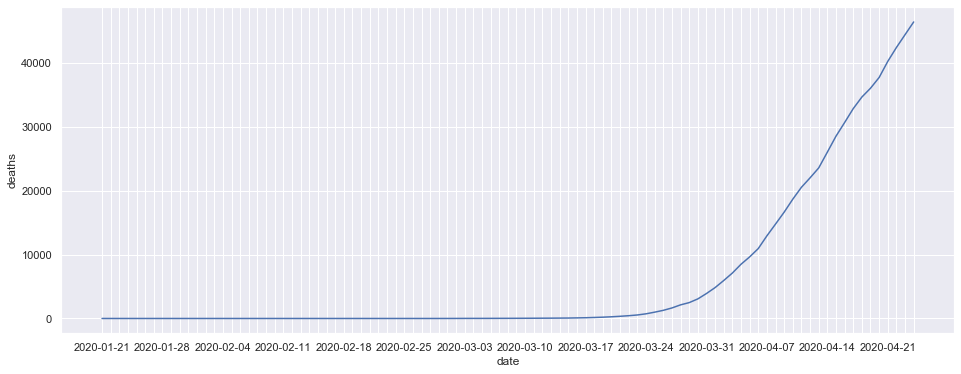

In [5]:
plot = sns.lineplot(x=us['date'], y=us['deaths'])
for i, label in enumerate(plot.get_xticklabels()):
    if i % 7 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plot

The USA shows a steep linear growth rate after the issuing of mass lockdowns.

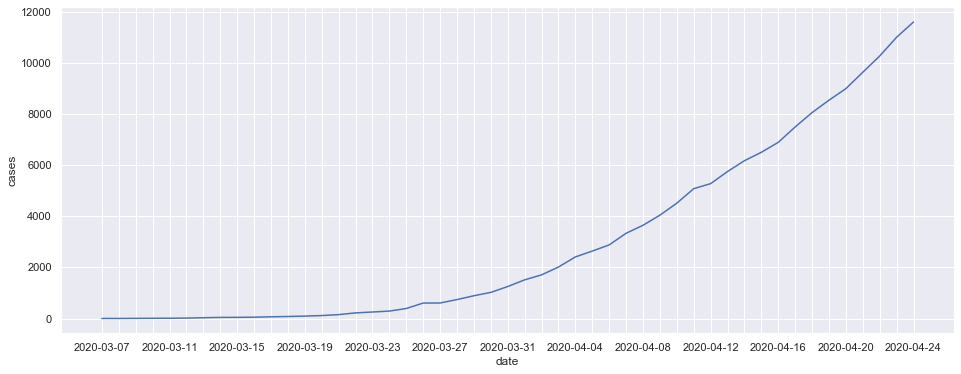

In [6]:
va = us_states[us_states.state == 'Virginia']
plot = sns.lineplot(x=va['date'], y=va['cases'])
for i, label in enumerate(plot.get_xticklabels()):
    if i % 4 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plot

The above graph shows how you can select and graph the caseload for a specific state - in this case Virginia.

Let's look at New York City.

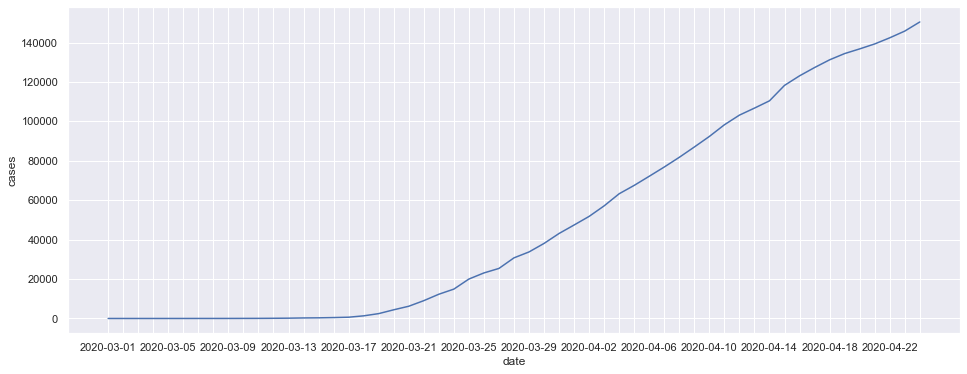

In [7]:
nyc = us_counties[us_counties.county == 'New York City']
plot = sns.lineplot(x=nyc['date'], y=nyc['cases'])
for i, label in enumerate(plot.get_xticklabels()):
    if i % 4 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plot

Growth is still very high in NYC, but it's showing small hints of slowing down.

But where is it speeding up? Can we predict where the next problem areas will be?

Let's see if we can predict what are the most problematic counties in the USA right now for coronavirus growth.

This is a relatively simple algorithm that computes the sharpness of growth in the past five days and ranks counties by this measure.

In [8]:
us_counties = us_counties[us_counties.county != 'Unknown']
us_counties['county_state'] = us_counties[['county', 'state']].apply(lambda x: ', '.join(x), axis=1)
us_counties['pct_change'] = us_counties.groupby('county_state')['cases'].pct_change(periods=5).replace([np.inf, -np.inf], np.nan).dropna()
final_list = us_counties.sort_values('pct_change', ascending=False)['county_state'].unique()[:10]
for item in final_list:
    print(item)

Bledsoe, Tennessee
DuPage, Illinois
Nobles, Minnesota
Suffolk, New York
Genesee, Michigan
Louisa, Iowa
Middlesex, Massachusetts
Durham, North Carolina
St. James, Louisiana
Jefferson, Louisiana


Let's look at Bledsoe, Tennessee:

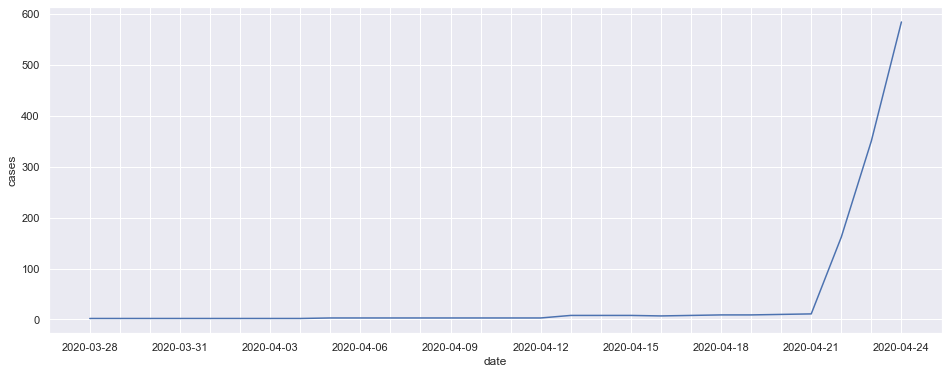

In [9]:
bledsoe = us_counties[us_counties.county_state == 'Bledsoe, Tennessee']
plot = sns.lineplot(x=bledsoe['date'], y=bledsoe['cases'])
for i, label in enumerate(plot.get_xticklabels()):
    if i % 3 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plot

That is a very steep rise...

Bledsoe is a county of about 15,000 people. Read this to understand [why their cases are this way](https://wdef.com/2020/04/24/bledsoe-prison-warping-covid-19-case-stats-county/).

## Dataset from Israel Ministry of Health

Israel released one of the most comprehensive public datasets for coronavirus. The dataset includes symptoms, test results, and rich epidemiological information for most coronavirus patients in the State of Israel. The detailed information is useful for symptom checkers and various forms of digital health technology.

In [10]:
corona_isolation_per_day = pd.read_excel(glob('israel_data/corona_isolation_per_day*.xlsx')[0])
corona_recovered = pd.read_excel(glob('israel_data/corona_recovered*.xlsx')[0])
corona_lab_tests = pd.read_excel(glob('israel_data/corona_lab_tests*.xlsx')[0])
corona_tested_individuals = pd.read_excel(glob('israel_data/corona_tested_individuals*.xlsx')[0])

In [11]:
symptom_labels = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
corona_positive = corona_tested_individuals[corona_tested_individuals.corona_result == 'חיובי']
print(f"Total Israeli positive cases: {len(corona_positive)}")
print("\nSymptom Counts")
num_symptoms = corona_positive.sum()
print(num_symptoms.to_string())
num_no_symptoms = len(corona_positive) - corona_positive[symptom_labels].any(axis=1).sum()
percent = "{:.0%}".format(num_no_symptoms/len(corona_positive))
print(f"\nTotal with no symptoms: {num_no_symptoms} (percent of positive: {percent})")
abroad = len(corona_positive[corona_positive.test_indication == 'Abroad'])
contact = len(corona_positive[corona_positive.test_indication == 'Contact with confirmed'])
comm_transmission = len(corona_positive[corona_positive.test_indication == 'Other'])
print(f"\nCase origins -- from abroad: {abroad}, from a close contact: {contact}, from community transmission: {comm_transmission}")
print(f"\nAverage time for recovery from first positive: {corona_recovered['days_between_pos_and_neg'].mean()} days" )

Total Israeli positive cases: 11585

Symptom Counts
cough                  5476.0
fever                  4903.0
sore_throat            1525.0
shortness_of_breath    1159.0
head_ache              2229.0

Total with no symptoms: 3450 (percent of positive: 30%)

Case origins -- from abroad: 1958, from a close contact: 5170, from community transmission: 4457

Average time for recovery from first positive: 13.117585576169324 days


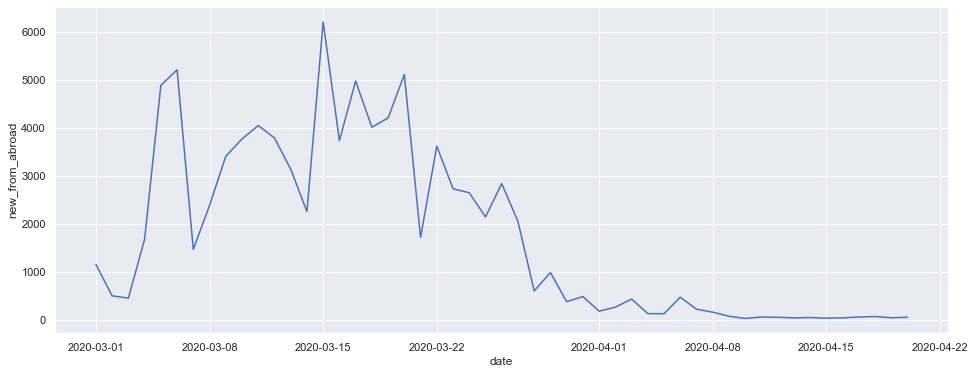

In [12]:
sns.lineplot(x=corona_isolation_per_day['date'], y=corona_isolation_per_day['new_from_abroad'])

Israel was the first country in the world to seal its borders to non-citizens entirely. The graph above shows the effect of a sudden rush of citizens coming back from abroad (as you can see from the numbers, often brining coronavirus with them) and the borders sealing.

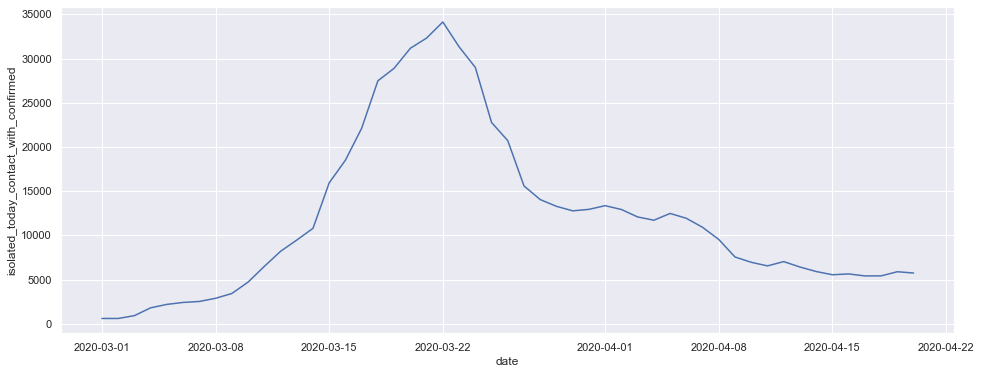

In [13]:
sns.lineplot(x=corona_isolation_per_day['date'], y=corona_isolation_per_day['isolated_today_contact_with_confirmed'])

The Israel Ministry of Health is responsible for issuing mandatory 14 day quarantines for individuals using a few contact tracing approaches. These quarantine orders peaked in early March and have been declining since, roughly following the case growth curve.

Download this notebook, try graphing some more counties or add your own analysis. Pull requests welcome.